# Edge, Line, and Corner Detection

An image gradient represents the change in intensity (brightness) of pixels in an image. It's used to detect edges—places where the intensity changes rapidly (e.g., from dark to light).

Mathematically, for a grayscale image:

- Bright areas -> high pixel values

- Dark areas -> low pixel values

A gradient measures:

- How much the pixel values change (magnitude)

- In what direction they change (orientation or angle)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Edge Detection

Edge detection aims to identify points in an image where intensity changes sharply. The three operators used—Sobel, Prewitt, and Canny—work by approximating the image gradient.

## 1. Sobel Operator

### 🔧 How it Works
- The Sobel operator is a **discrete differentiation operator** that computes the gradient of the image intensity.
- It applies two **3x3 convolution kernels**:
  - One for horizontal direction $G_x$
  - One for vertical direction $G_y$

### 🔧 How it Works
The gradient magnitude is calculated as:

$$
G = \sqrt{G_x^2 + G_y^2}
$$

Where:
- $G_x$: horizontal gradient  
- $G_y$: vertical gradient


- Highlights regions with rapid intensity change.

### Interpretation
- Sobel shows **curved and detailed edges** clearly.
- Compared to Prewitt, Sobel gives **stronger edge responses** due to heavier center weights.



In [ ]:
def sobel_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)
    return sobel

## 2. Prewitt Operator

### How it Works
- Similar to Sobel, but uses **equal-weight kernels**:

$$
G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}
\quad
$$

$$
G_y =
\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

- Magnitude computed same as Sobel: $$\sqrt{G_x^2 + G_y^2}\$$

### Interpretation
- Detects edges but **less intense** than Sobel.
- **More sensitive to noise**, less ideal for complex images.


In [ ]:
def prewitt_edge_detection(image):
    """Apply Prewitt operator for edge detection."""
    Gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    Gy = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)

    grad_x = cv2.filter2D(image, cv2.CV_32F, Gx)
    grad_y = cv2.filter2D(image, cv2.CV_32F, Gy)

    # Ensure both gradients are float32
    grad_x = grad_x.astype(np.float32)
    grad_y = grad_y.astype(np.float32)

    magnitude = cv2.magnitude(grad_x, grad_y)  # Compute magnitude
    return np.uint8(magnitude)  # Convert back to uint8 for display


## 3. Canny Edge Detection

### How it Works
1. **Gaussian Smoothing**: Reduces noise
2. **Compute Gradients**: Using Sobel filters
3. **Non-Maximum Suppression**: Thins edges
4. **Double Thresholding**: Detects strong and weak edges
5. **Edge Tracking by Hysteresis**: Connects weak edges to strong ones

### Interpretation
- Produces **thin, well-defined edges**
- **Less noise** compared to Sobel and Prewitt
- **Captures finer details** accurately




In [ ]:
def canny_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(gray, 100, 200)
    return canny


## 4. Harris Corner Detector

### How it Works
1. Compute image gradients $ I_x, I_y $
2. Form structure tensor:

$$
M =
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$

3. Corner response:

$$
R = \text{det}(M) - k \cdot (\text{trace}(M))^2
$$

(The trace of a matrix is the sum of its eigenvalues)

Where $ k $ is typically between **0.04 and 0.06**.

### Interpretation
- Corners marked in **blue**
- Detects **intersections and corners**
- **Less noisy** than manual version

In [ ]:
def harris_corner_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    image[dst > 0.01 * dst.max()] = [0, 0, 255]
    return image

In [ ]:
def harris_corner_manual(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    window_size = 3
    offset = window_size // 2
    R = np.zeros_like(gray)

    for y in range(offset, gray.shape[0] - offset):
        for x in range(offset, gray.shape[1] - offset):
            Sxx = np.sum(Ixx[y-offset:y+offset+1, x-offset:x+offset+1])
            Syy = np.sum(Iyy[y-offset:y+offset+1, x-offset:x+offset+1])
            Sxy = np.sum(Ixy[y-offset:y+offset+1, x-offset:x+offset+1])

            det = (Sxx * Syy) - (Sxy ** 2)
            trace = Sxx + Syy
            R[y, x] = det - 0.04 * (trace ** 2)

    image[R > 0.01 * R.max()] = [0, 255, 0]
    return image

## 5. Hough Transform for Line Detection (Bottom-Right)

### How it Works
1. Use **Canny Edge Detection**
2. Map edge points $ (x, y) $ to Hough space:

$$
\rho = x \cos(\theta) + y \sin(\theta)
$$

Where:
- $\rho \ $: distance from origin to line
- $\theta \ $: angle of normal to the line

3. Find peaks in Hough space → line detections

### Interpretation
- Detected lines shown in **green**
- Some **false positives** due to complex edges
- Effective for **structured scenes** (roads, buildings)


In [ ]:
def hough_line_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image


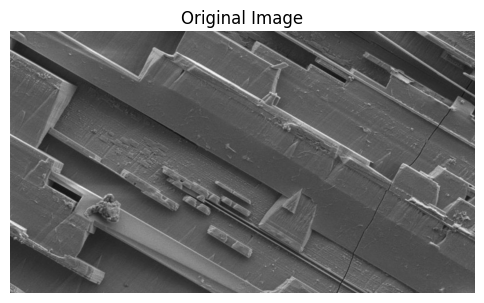

In [ ]:
image = cv2.imread('image13.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

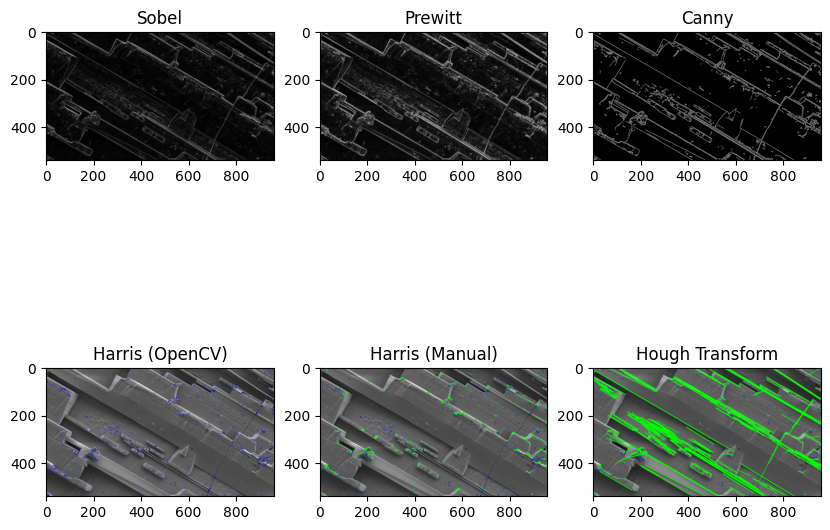

In [ ]:
image = cv2.imread('image13.jpg') # Steel under microscope
plt.figure(figsize=(10, 8))
plt.subplot(231), plt.imshow(sobel_edge_detection(image), cmap='gray'), plt.title('Sobel')
plt.subplot(232), plt.imshow(prewitt_edge_detection(image), cmap='gray'), plt.title('Prewitt')
plt.subplot(233), plt.imshow(canny_edge_detection(image), cmap='gray'), plt.title('Canny')
plt.subplot(234), plt.imshow(harris_corner_detection(image)), plt.title('Harris (OpenCV)')
plt.subplot(235), plt.imshow(harris_corner_manual(image)), plt.title('Harris (Manual)')
plt.subplot(236), plt.imshow(hough_line_detection(image)), plt.title('Hough Transform')

plt.show()